In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,Normalize
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [57]:
!pwd

/Volumes/HDD750GB/Programs/Fisher/github/Wfirst/Core


In [58]:
#df = pd.read_csv('../tt0_2.zphot',sep=' ',index_col=False)#,header=None)
df_w=pd.read_csv('../Core_WFRIST.csv',sep=' ',index_col=False)

#df.columns   = ['id', 'ztrue', 'zphot', 'zphoterr', 'N_cm']
df_w.columns = ['ztrue', 'zphot']

#df = df.iloc[:, :-1]
#df_w = df_w.iloc[:, :-1]

#df   = df.sort_values(by=['ztrue'])   
df_w = df_w.sort_values(by=['ztrue'])   

#df = df[df.ztrue<=1.2]
#df_w = df_w[df_w.ztrue<=1.2]

In [61]:
# Based on : https://github.com/dirac-institute/CMNN_Photoz_Estimator/blob/master/cmnn_analysis.py
def CORiqrbias(zphot,ztrue):
    ###   thresh_COR : zspec-zphot threshold to define "catastrophic outlier rejection"
    thresh_COR = 1.5

    ### Identify the subset of catastrophic outlier-rejected test galaxies in the requested bin
    tx = np.where( ( np.abs( zphot - ztrue ) < thresh_COR ) )[0]
    CORzspec = ztrue[tx]
    CORzphot = zphot[tx]

    ### Define bin_dzo1pzp for use in all stats
    CORdzo1pzp = ( CORzspec - CORzphot ) / ( float(1.0) + CORzphot )
    CORdzo1pzp=np.array(CORdzo1pzp)
    ### COR Intraquartile Range
    q75, q25   = np.percentile( CORdzo1pzp, [75 ,25] )
    CORIQR     = ( q75 - q25 )
    CORIQRstdd = ( q75 - q25 ) / float(1.349)
    tx         = np.where( ( CORdzo1pzp > q25 ) & ( CORdzo1pzp < q75 ) )[0]

    CORIQRbias = np.mean( CORdzo1pzp[tx] )
    return CORIQRbias

In [62]:
   '''
    bins  = np.linspace(0,1.2,13)
    start = (bins[0] + bins[1])/2.; end = (bins[-1] + bins[-2])/2.

    label = np.linspace(start,end,12)
    print(label)
    
    bins  = np.linspace(0,1.2,25)
    start = (bins[0] + bins[1])/2.; end = (bins[-1] + bins[-2])/2.

    label = np.linspace(start,end,24)
    print(label)
    '''

'\n bins  = np.linspace(0,1.2,13)\n start = (bins[0] + bins[1])/2.; end = (bins[-1] + bins[-2])/2.\n\n label = np.linspace(start,end,12)\n print(label)\n \n bins  = np.linspace(0,1.2,25)\n start = (bins[0] + bins[1])/2.; end = (bins[-1] + bins[-2])/2.\n\n label = np.linspace(start,end,24)\n print(label)\n '

In [121]:
main_N = np.array([   74,  1230,   960,  1515,  3753,  5961,  5047,  4114,  6569,
        8744,  7517,  8507, 10466,  6803,  6438,  8143,  7634,  5109,
        6477,  7078,  4823,  4184,  3824,  3280])

In [148]:
main_N.sum()

128250

In [126]:
def bias(df):
    n_bin = 24;#12
    bins  = np.linspace(0,1.2,n_bin+1)
    start = (bins[0] + bins[1])/2.; end = (bins[-1] + bins[-2])/2.

    label = np.linspace(start,end,n_bin)
    size=main_N#128250;#len(df)
    df['bin_z'] = pd.cut(df.ztrue, bins=bins, labels=label)
    df = df[df['bin_z'].notna()]
    N=[];cor=[];zp=[];zs=[];fcore=[];count=0;
    for each in label:
        x = df[df['bin_z'] == each]
        N.append(len(x))
        cor.append(CORiqrbias(np.array(x.zphot),np.array(x.ztrue))) # Call the COR_IQR Function
        zp.append(np.mean(x.zphot))
        zs.append(np.mean(x.ztrue))
        fcore.append(len(x)/size[count])
        count+=1
    N = pd.DataFrame(np.array(N))
    #N.columns = ['N']
    N.reset_index(drop=True, inplace=True)
    cor = pd.DataFrame(cor)
    zs = pd.DataFrame(zs)
    zp = pd.DataFrame(zp)
    l = pd.DataFrame(label)   
    fcore = pd.DataFrame(fcore)
    N =  pd.concat([l,N,zs,zp,cor,fcore],axis=1,ignore_index=True)
    N.columns = ['z','N','z_true','zphot','bias','fcore']
    #N = N.iloc[0:12 , : ] # 12 Bins
    return N

In [127]:
b_w= bias(df_w)
#b = bias(df)

In [129]:
print('Sum of total Fraction ')
b_w.fcore.sum()/24

Sum of total Fraction 


0.9603782144644608

Text(0, 0.5, 'CORE Bias')

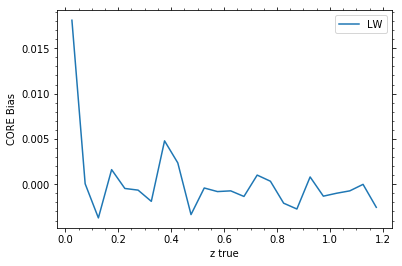

In [67]:
fig, ax = plt.subplots()
#plt.plot(b.z,b.bias,label='LSST')
plt.plot(b_w.z,-b_w.bias,label='LW')
#plt.plot(b.z,b.fcore,label='LSST-f')
#plt.plot(b_w.z,b_w.fcore,label='LW-f')
plt.legend()
ax.minorticks_on()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.xlabel('z true')
plt.ylabel('CORE Bias')

Text(0, 0.5, 'F Core')

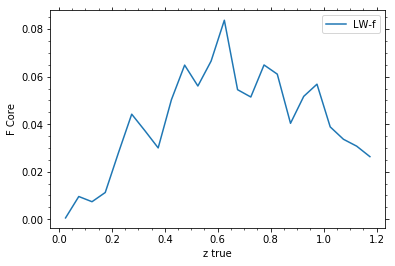

In [68]:
fig, ax = plt.subplots()
#plt.plot(b.z,b.bias,label='LSST')
#plt.plot(b_w.z,b_w.bias,label='LW')
#plt.plot(b.z,b.fcore,label='LSST-f')
plt.plot(b_w.z,b_w.fcore,label='LW-f')
plt.legend()
ax.minorticks_on()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.xlabel('z true')
plt.ylabel('F Core')

Text(0, 0.5, 'F Core*Bias')

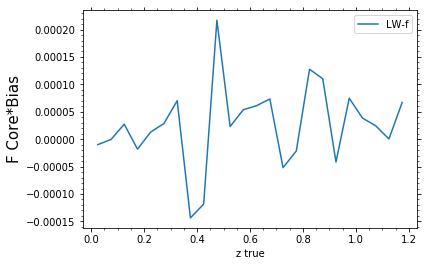

In [69]:
fig, ax = plt.subplots()
#plt.plot(b.z,b.bias,label='LSST')
#plt.plot(b_w.z,b_w.bias,label='LW')
#plt.plot(b.z,b.bias*b.fcore,label='LSST-f')
plt.plot(b_w.z,b_w.bias*b_w.fcore,label='LW-f')
plt.legend()
ax.minorticks_on()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.xlabel('z true')
plt.ylabel('F Core*Bias',fontsize=15)

In [70]:
#b.to_csv('interpolated_LSST.csv',sep = ' ',index = False)
#b_w.to_csv('interpolated_LW.csv',sep = ' ',index = False)

In [71]:
lsst_old = pd.read_csv('../../interpolated_new_2.csv',sep =' ' )# cormean, CORbias. new2 = Cormean,CorIQRbias

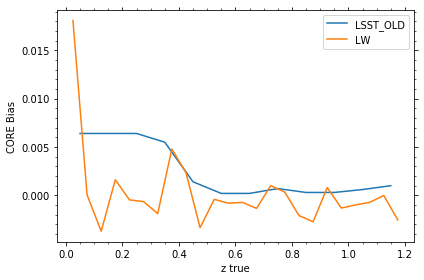

In [72]:
fig, ax = plt.subplots()
plt.plot(lsst_old.z,lsst_old.bias,label='LSST_OLD')
#plt.plot(b.z,(-b.bias),label='LSST')
plt.plot(b_w.z,(-b_w.bias),label='LW')
plt.legend()
ax.minorticks_on()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.xlabel('z true')
plt.ylabel('CORE Bias')
plt.tight_layout()
#plt.savefig('../Plot/Core_Bias.pdf',bbox_inches='tight')

In [73]:
# To compare with Interpolation from Melissa's data
LW_interp = pd.read_csv('interpolated_bias_LW_Melissa.csv',sep=' ')

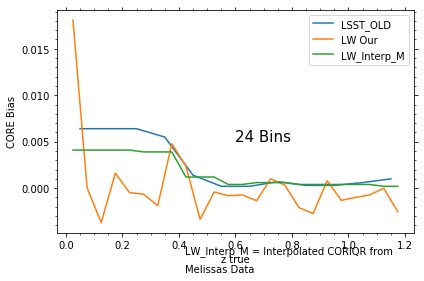

In [74]:
fig, ax = plt.subplots()
plt.plot(lsst_old.z,lsst_old.bias,label='LSST_OLD')
#plt.plot(b.z,(b.bias),label='LSST_NEW Our')
plt.plot(b_w.z,-(b_w.bias),label='LW Our')
plt.plot(LW_interp.z,(LW_interp.bias),label='LW_Interp_M') # M = Melissa's data
plt.legend()
ax.minorticks_on()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.xlabel('z true')
plt.ylabel('CORE Bias')

#plt.text(0.4,-0.0017,'LW_Interp_M = Interpolated CORIQR from',fontsize=10);plt.text(0.4,-0.0024,'Melissas Data ',fontsize=10);plt.text(0.5,0.005,'12 Bins',fontsize=15)

plt.text(0.42,-0.007,'LW_Interp_M = Interpolated CORIQR from',fontsize=10);plt.text(0.42,-0.009,'Melissas Data ',fontsize=10);plt.text(0.6,0.005,'24 Bins',fontsize=15)

plt.tight_layout()
#plt.savefig('../Plot/Core_Bias_Compare_w_Melissa_24b.pdf',bbox_inches='tight')

In [99]:
LW_outlier = pd.read_csv('Catastrophic_tzpz_WFIRST_24_intersection.csv',sep=' ' )#Catastrophic_tzpz_WFIRST_24.csv

In [130]:
f_t = (LW_outlier.F+b_w.fcore) # Adding the fraction bin by bin for the outlier and the core

In [131]:
print('***The Net sum of the fractions, i.e. f_total :***')
f_t.sum()/24

***The Net sum of the fractions, i.e. f_total :***


0.9995286416980722

In [133]:
(LW_outlier.F/24.+b_w.fcore/24.).sum()

0.9995286416980721

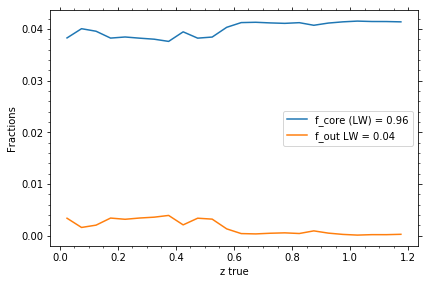

In [146]:
fig, ax = plt.subplots()
plt.plot(b_w.z,b_w.fcore/24.,label='f_core (LW) = %.2f'%((b_w.fcore/24).sum()))
plt.plot(b_w.z,LW_outlier.F/24.,label='f_out LW = %.2f'%((LW_outlier.F/24.).sum()))
#plt.plot(b_w.z,LW_outlier.F/24.+b_w.fcore/24.,label='f_total LW ')
plt.legend()
plt.xlabel('z true')
plt.ylabel('Fractions')
plt.tight_layout()
ax.minorticks_on()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.savefig('../Plot/Fractions_LW.pdf',bbox_inches='tight')

In [151]:
for i in range(24):
    print(b_w.fcore[i]+LW_outlier.F[i])

1.0
1.0
0.9989583333333333
1.0
0.9994670929922729
0.999832242912263
0.9990093124628492
0.9968400583373845
0.9974120870756584
0.9990850869167429
0.999866968205401
0.9998824497472669
0.999904452512899
0.9998530060267529
1.0
0.9997543902738548
0.999869007073618
1.0
0.9998456075343524
0.9995761514552134
0.9997926601700187
1.0
0.9997384937238494
1.0
